
<center>Yanis HALLOUM 

## Table of Content


* [Scenario I: An Angry Customer...](#scenario-i-an-angry-customer) 
    * [Part I](#Subsection-1)
         * [Introduction](#Introduction)
         * [Methodology](#Methodology)
    * [Part II](#Subsection-2)
         * [Introduction](#Introduction)
         * [Methodology](#Methodology)
* [Scenario II: Shaken but not (perfectly stirred)](#Part-2---Section-Title) 
    * [Part I](#Subsection-1)
         * [Introduction](#Introduction)
         * [Methodology](#Methodology)
    * [Part II](#Subsection-2)
         * [Introduction](#Introduction)
         * [Methodology](#Methodology)

**Basic packages required for labs**

The Python kernel is initialized for Cantera, Numpy, MatplotLib and yaml with the commands below.

In [1]:
%matplotlib inline
import cantera as ct 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 

## Effect of Heavy Hydrocarbons on autoignition risks in the premixer

#### Introduction

Heavy Hydrocarbons (HHC) such as Butane and Pentane have different combustion behavior in comparison to standard natural gas. Additionally, Dry Low Emission (DLE) gas turbines are sensitive to fuel composition because of their short premixer residence times (2–20 ms). In this regard, an operator can report random autoignition events, possibly triggered by  spikes in HHC (butane, pentane) in the natural gas. This report will compute ignition delays for different fuel mixtures under turbine conditions (P = 40 bar, T_preheat = 890 K, φ = 0.625) and evaluate the risk of autoignition in the premixer.


#### Methodology

The goal of this study is to analyze the combustion behavior and ignition characteristics of a **Dry Low Emissions (DLE)** gas turbine under varying natural gas compositions. The analysis focuses on identifying days with **Butane** and **Pentane spikes**, which can increase autoignition risk, comptuting **Ignition Delays**, **Lower Heating Value (LHV)** and **Air–Fuel Ratio (AFR)** for daily gas mixture.

**Turbine operating conditions:**

| Parameter | Symbol | Value | Unit |
|------------|---------|--------|------|
| Combustion pressure | $P$ | 40 | bar |
| Preheat temperature | $T_\text{in}$ | 890 | K |
| Power output | $\text{P}_\text{out}$ | 60 | MW |
| Thermal efficiency | $\eta$ | 0.42 | – |
| Excess air factor | $\lambda$ | 2.0 | – |

**Fuel species considered:**

$\text{CH}_4, \text{C}_2\text{H}_6, \text{C}_3\text{H}_8, \text{C}_4\text{H}_{10}, \text{C}_5\text{H}_{12}$

---

**Ignition delays** were computed using the `nuig_3005.yaml` as it includes C1–C5 mechanism. Fuel compositions for each day were converted from volume percent to mole fraction. The autoignition criteria was arbitrarily defined as a temperature rise **ΔT = 400 K** in a constant-pressure ideal gas reactor. The calculated ignition delays were compared to the premixer residence time distribution (2–20 ms) to evaluate autoignition risk. We define **φ = 0.625** because for DLEs, φ is between 0.50 and 0.75 [c.f  "Prediction of Dry-Low Emission Gas Turbine Operating Range from Emission Concentration Using Semi-Supervised Learning" by Mochammad Faqih].

---

The **mixture LHV** is the mass-fraction-weighted average of the component LHVs:

$$
LHV_\text{mix} = \sum_i Y_i \, LHV_i
$$

where each **mass fraction** $Y_i$ is computed from its mole fraction $x_i$ and molecular weight $M_i$:

$$
Y_i = \frac{x_i M_i}{\sum_j x_j M_j}
$$

The resulting $LHV_\text{mix}$ is expressed in **J/kg**.

---

The **stoichiometric Air-Fuel Ratio** will be computed using the following equations: 

For a hydrocarbon with the general formula $C_xH_y$, the complete combustion reaction is:

$$
C_xH_y + \left(x + \frac{y}{4}\right) O_2 \rightarrow x CO_2 + \frac{y}{2} H_2O
$$

The **moles of O₂ required** per mole of fuel are:

$$
n_{O_2,i} = x + \frac{y}{4}
$$

Since air contains 3.76 moles of N₂ per mole of O₂, the **mass of air required** for 1 mole of fuel *i* is:

$$
m_\text{air,i} = 4.76 \, n_{O_2,i} \, M_\text{air}
$$

with $M_\text{air} = 28.97 \times 10^{-3} \, \text{kg/mol}$.

The **stoichiometric air–fuel ratio** for the mixture (in kg air/kg fuel) is then:

$$
AFR_\text{stoich} = \frac{\sum_i x_i \, m_\text{air,i}}{\sum_i x_i \, M_i}
$$

---

The **fuel mass flow rate** required for the given power output is:

$$
\dot{m}_\text{fuel} = \frac{Power}{\eta \cdot LHV_\text{mix}}
$$

The corresponding **air mass flow rate** at excess air factor $\lambda$ is:

$$
\dot{m}_\text{air} = AFR_\text{stoich} \cdot \dot{m}_\text{fuel} \cdot \lambda
$$

**Simulate the DLE turbine and compute the ignition delays for every daily composition**:

In [10]:
# Gas turbine and simulation paramaters

P_bar = 40.0                   # Bar
T_preheat = 890.0              # K
phi = 0.625                    
mechanism = "nuig_3005.yaml"   # C1-C5 mechanism
res_time_range_ms = (2, 20)    # Turbine residence time range [ms]
max_sim_time = 0.1             # Simulation time [s]   

In [11]:
# Read fuel composition file

fuel_data = pd.read_csv("fuel_composition.csv")

fuel_columns = fuel_data.columns[1:]

# Mole fraction conversion
for c in fuel_columns:
    fuel_data[c] = fuel_data[c] / 100.0

In [12]:
# Spike detection

mean_butane = fuel_data["Butane"].mean()
mean_pentane = fuel_data["Pentane"].mean()

threshold_butane = mean_butane   # spike if > mean
threshold_pentane = mean_pentane 

fuel_data["Butane_spike"] = fuel_data["Butane"] > threshold_butane
fuel_data["Pentane_spike"] = fuel_data["Pentane"] > threshold_pentane

butane_days = fuel_data[fuel_data["Butane_spike"]]
pentane_days = fuel_data[fuel_data["Pentane_spike"]]
natural_days = fuel_data[~(fuel_data["Butane_spike"] | fuel_data["Pentane_spike"])]

# We will only compute the ignition delays for one day of each fuel composition as they will return the same result
first_butane_day = fuel_data[fuel_data["Butane_spike"]].iloc[0] if any(fuel_data["Butane_spike"]) else None
first_pentane_day = fuel_data[fuel_data["Pentane_spike"]].iloc[0] if any(fuel_data["Pentane_spike"]) else None
first_natural_day = fuel_data[~(fuel_data["Butane_spike"] | fuel_data["Pentane_spike"])].iloc[0]

print("Fuel composition spikes")
print(f"\nButane spikes : {list(butane_days['Day'].values)}\n")
print(f"\nPentane spikes : {list(pentane_days['Day'].values)}\n")
print(f"\nNatural Gas days : {list(natural_days['Day'].values)}\n")

Fuel composition spikes

Butane spikes : [np.int64(5), np.int64(20), np.int64(30)]


Pentane spikes : [np.int64(10), np.int64(15), np.int64(25)]


Natural Gas days : [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(26), np.int64(27), np.int64(28), np.int64(29)]



### 3 different gas compositions 

- **Days 5, 20, and 30 → Spike in Butane**  
  **Full composition:**  
  - 76% Methane  
  - 5% Ethane  
  - 3% Propane  
  - 15% **Butane**  
  - 1% Pentane  

---

- **Days 10, 15, and 25 → Spike in Pentane**  
  **Full composition:**  
  - 66% Methane  
  - 5% Ethane  
  - 3% Propane  
  - 1% Butane  
  - 25% **Pentane**

---

- **All other days → Natural Gas Composition**  
  **Full composition:**  
  - 90% Methane  
  - 5% Ethane  
  - 3% Propane  
  - 1% Butane  
  - 1% Pentane  


In [13]:
# Initialize Cantera gas

gas = ct.Solution(mechanism)
oxidizer = {"O2": 1, "N2": 3.76}

In [14]:
# Ignition delay function

def ignition_delay(gas, fuel_dict, label, day):
    print(f"\nDay {day}: {label}")
    gas.set_equivalence_ratio(phi, fuel_dict, oxidizer)
    gas.TP = T_preheat, P_bar * 1e5

    r = ct.IdealGasConstPressureMoleReactor(gas)
    sim = ct.ReactorNet([r])
    sim.derivative_settings = {"skip-third-bodies": True, "skip-falloff": True}
    sim.preconditioner = ct.AdaptivePreconditioner()

    t = 0.0
    maxtime = max_sim_time
    T_init = r.T
    times = []
    temps = []
    ignition_time = None

    while t < maxtime:
        t = sim.step()
        times.append(t)
        temps.append(r.T)

        # Auto ignition criteria: Temperature rise of 400 K
        if (r.T - T_init) > 400:
            ignition_time = t
            print(f"Auto ignition detected at {t*1000:.2f} ms, T = {r.T:.1f} K")
            break

    if ignition_time is None:
        print(f"No auto ignition detected before {maxtime*1000:.0f} ms")
        ignition_ms = np.nan
        risk = "No ignition"
    else:
        ignition_ms = ignition_time * 1000.0
        if ignition_ms <= res_time_range_ms[1]:
            risk = "Possible autoignition (τ <= 20 ms)"
        else:
            risk = "No autoignition (τ > 20 ms)"

    return {
        "Day": day,
        "Case": label,
        "Ignition Delay (ms)": ignition_ms,
        "Max Temp (K)": max(temps),
        "Risk": risk
    }


In [15]:
# Ignition delay simulation

results = []

# Natural gas fuel
fuel_nat = {
    "CH4": first_natural_day["Methane"],
    "C2H6": first_natural_day["Ethane"],
    "C3H8": first_natural_day["Propane"],
    "C4H10": first_natural_day["Butane"],
    "NC5H12": first_natural_day["Pentane"]
}
results.append(ignition_delay(gas, fuel_nat, "Natural Gas", first_natural_day["Day"]))

# Butane spike fuel
if first_butane_day is not None:
    fuel_but = {
        "CH4": first_butane_day["Methane"],
        "C2H6": first_butane_day["Ethane"],
        "C3H8": first_butane_day["Propane"],
        "C4H10": first_butane_day["Butane"],
        "NC5H12": first_butane_day["Pentane"]
    }
    results.append(ignition_delay(gas, fuel_but, "Butane Spike", first_butane_day["Day"]))

# Pentane spike fuel 
if first_pentane_day is not None:
    fuel_pen = {
        "CH4": first_pentane_day["Methane"],
        "C2H6": first_pentane_day["Ethane"],
        "C3H8": first_pentane_day["Propane"],
        "C4H10": first_pentane_day["Butane"],
        "NC5H12": first_pentane_day["Pentane"]
    }
    results.append(ignition_delay(gas, fuel_pen, "Pentane Spike", first_pentane_day["Day"]))



Day 1: Natural Gas
Auto ignition detected at 26.02 ms, T = 1292.1 K

Day 5: Butane Spike
Auto ignition detected at 9.36 ms, T = 1291.9 K

Day 10: Pentane Spike
Auto ignition detected at 2.79 ms, T = 1290.2 K


In [16]:
# Results export

df_results = pd.DataFrame(results)
os.makedirs("results", exist_ok=True)
df_results.to_csv("./results/ignition_results.csv", index=False)

print(df_results)
print("\nResults saved as ./results/representative_ignition_results.csv")

   Day           Case  Ignition Delay (ms)  Max Temp (K)  \
0    1    Natural Gas            26.017894   1292.136787   
1    5   Butane Spike             9.358108   1291.901638   
2   10  Pentane Spike             2.785603   1290.208321   

                                 Risk  
0         No autoignition (τ > 20 ms)  
1  Possible autoignition (τ <= 20 ms)  
2  Possible autoignition (τ <= 20 ms)  

Results saved as ./results/representative_ignition_results.csv


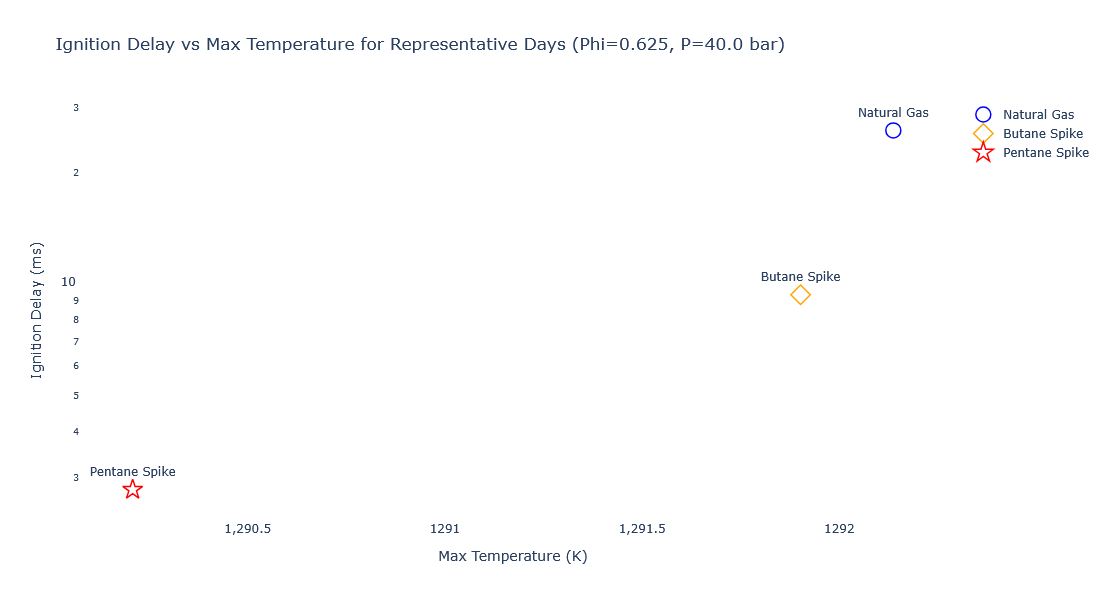

In [17]:
import plotly.graph_objs as go
import plotly
plotly.offline.init_notebook_mode(connected=True)

max_temps = df_results["Max Temp (K)"].tolist()
ignition_delays = df_results["Ignition Delay (ms)"].tolist()
cases = df_results["Case"].tolist()

colors = ['blue', 'orange', 'red']  
symbols = ['circle-open','diamond-open','star-open']

traces = []
for i, case in enumerate(cases):
    trace = go.Scatter(
        x=[max_temps[i]],
        y=[ignition_delays[i]],
        mode='markers+text',
        name=case,
        text=[case],
        textposition='top center',
        marker=dict(
            color=colors[i],
            symbol=symbols[i],
            size=15,
            line=dict(color='black', width=1.5)
        )
    )
    traces.append(trace)

layout = go.Layout(
    title=f'Ignition Delay vs Max Temperature for Representative Days (Phi={phi}, P={P_bar} bar)',
    xaxis=dict(title='Max Temperature (K)'),
    yaxis=dict(title='Ignition Delay (ms)', type='log'),
    width=800,
    height=600,
    paper_bgcolor='white',
    plot_bgcolor='white',
    showlegend=True
)

fig = go.Figure(data=traces, layout=layout)
plotly.offline.iplot(fig)

#### Results and Discussion

| Day | Case            | Ignition Delay (ms) | Max Temp (K) | Risk |
|-----|----------------|------------------|-------------|------|
| 1   | Natural Gas    | 26.02            | 1292.1      | Low  |
| 5   | Butane Spike   | 9.36             | 1291.9      | Elevated |
| 10  | Pentane Spike  | 2.79             | 1290.2      | High |

**Probability of Autoignition:**  

Assuming a distribution of residence times in the premixer ranging from $ \tau_\text{res,min} = 2 \text{ms}$ to $\tau_\text{res,max} = 20 \text{ms}$, the likelihood of autoignition depends on whether the ignition delay $ \tau_\text{ign}$ is within this range. 
- For **natural gas**: $ \tau_\text{ign} $ = 26 ms > $\tau_\text{res,max}$ -> autoignition is unlikely. 
- For **butane spikes** ($ \tau_\text{ign} $ = 9.36 ms < $\tau_\text{res,max}$). 
- For **pentane spikes** ($ \tau_\text{ign} $ = 2.78 ms < $\tau_\text{res,max}$).

For days with spikes, some fraction of the mixture will ignite while passing through the premixer. 
If the mixture recirculates or passes through multiple times, the cumulative probability increases: even a small pocket with $\tau_\text{ign}$ < $\tau_\text{res,max}$ can trigger autoignition, increasing the risk.

We define **n**, the number of times the mixture could potentially recirculate or pass through the premixer before ignition:

$$
n = \left\lfloor \frac{\tau_\text{res,max}}{\tau_\text{ign}} \right\rfloor
$$

- **Natural Gas:**  
  $
  n = \left\lfloor \frac{20}{26.02} \right\rfloor $ = 0 
    
  $ \tau_\text{ign} > \tau_\text{res,max}$  → autoignition is unlikely. 

- **Butane Spike:**  
  $
  n = \left\lfloor \frac{20}{9.36} \right\rfloor = 2
  $ 
  A portion of the mixture may ignite during one of the first few passes. Probability increases with recirculation.

- **Pentane Spike:**  
  $
  n = \left\lfloor \frac{20}{2.79} \right\rfloor = 7
  $  
  Very short $\tau_\text{ign}$ → high likelihood of autoignition even in the first pass.


Assuming independent passes, the cumulative probability **P** that at least one pocket ignites after **n passes** can be approximated by:


$$P = 1 - (1 - p_\text{single} )^n$$


where **$ p_\text{single} $** is the probability of ignition in a single pass.

Assuming 0 < **$ p_\text{single} $** < 1, then the function n -> $(1 - p_\text{single} )^n$ decreases as n increases. Then P gets closer to one as n increases. 
- Natural Gas: n = 0 → P ≈ 0%  
- Butane Spike: n = 2 → P ≈ higher  
- Pentane Spike: n = 7 → P ≈ highest  

> Pentane spikes present the highest autoignition risk, followed by butane spikes, while natural gas is unlikely to ignite in the premixer under these operating conditions.

---

**Effect of Higher Hydrocarbons:**  
- HHCs such as butane and pentane have **larger molecular structures** → longer carbon chains and more available hydrogen atoms → increases reactivity of the fluid and the generation of radicals during combustion.
- More **C-C** and **C-H** bonds, notably **β-hydrogens** (H atoms on the second C atom from a functional group)
- β-hydrogens are more easily removed by reactive radicals (OH, O or H) which causes a **radical chain reaction**.
      - The process begins with **H-abstraction**:
  $$
  \text{RH (hydrocarbon)} + \text{OH} \rightarrow \text{R· (radical)} + \text{H₂O}
  $$
      - The formed alkyl radicals **R·** undergo **β-scission**, fragmenting into smaller and more reactive radicals (CH₃ or C₂H₅).
- These radicals then propagate oxidation and heat release.
- The **chain reaction accelerates** as more radicals are produced:

  - **Initiation:** formation of radicals via H-abstraction.  
  - **Propagation:** radicals react with O₂ and hydrocarbons to sustain the chain.  
  - **Branching:** radical recombination and oxidation produce multiple new radicals (OH, H, O).  
  - This cascade shortens the **ignition delay time (τₙₗₙ)** since the radical pool grows faster → **higher hydrocarbons ignite much more rapidly** than methane-based mixtures.

  
 
- **Natural gas (mostly methane)** has a long ignition delay (26 ms) because methane’s C–H bonds are **strong and difficult to break**, demanding large activation energy to form radicals.
- **Pentane vs Butane:** pentane has more β-hydrogens and longer carbon chain → generates more radicals → ignition delay shorter than butane. 
  → τₙₗₙ drops dramatically to ~2.8 ms.

---

**Effect of hydrogen admixing:**  
According to S.M.Frolov in "Self-ignition of hydrocarbon–hydrogen–air mixtures"
- At **T < ~1050 K**, adding hydrogen can **increase ignition delay** → hydrogen reacts with hydrocarbon intermediates forming less reactive species → chain branching is inhibited.  
- At **T > ~1050 K** (our case), adding hydrogen **decreases ignition delay** → hydrogen acts as a promoter, accelerating radical chain propagation.  
- **Implication:** Hydrogen can either inhibit or promote ignition depending on temperature, because it reacts with radicals and intermediates, affecting chain branching. In our case, hydrogen addition increases reactivity. 

---

**Additional thought: Why are max temperatures so close, and why is the max temperature for the natural gas composition higher ?**
The ignition simulations show max temperatures around 1290–1292 K for all fuels. At constant pressure, the adiabatic flame temperature mainly depends on the equivalence ratio φ and the stoichiometry, not on the specific hydrocarbon.
According to “Oxidation of C1–C5 Alkane Quinternary Natural Gas Mixtures” by Healy et al:
For C₁–C₅ fuels at the same φ: The energy released per mole of O₂ is quite similar. The heat capacities of the combustion products (CO₂, H₂O, N₂) are nearly the same → the adiabatic temperatures end up very close.

The natural gas mixture ignites later (~26 ms) and releases heat more gradually, which can lead to a slightly higher temperature.

**Let's compute $LHV_{mix}$, $\dot{m}_{air}$ and $\dot{m}_{fuel}$**:

In [18]:
# Constants & LHVs (J/kg)
# LHV values (mass basis) — https://www.engineeringtoolbox.com/fuels-higher-calorific-values-d_169.html.
LHV = {
'CH4': 50.0e6, # J/kg
'C2H6': 47.8e6,
'C3H8': 46.4e6,
'C4H10': 45.3e6,
'NC5H12': 45.4e6
}

# Molecular weights (g/mol) - https://www.engineeringtoolbox.com/molecular-weight-gas-vapor-d_1156.html
MW = {'CH4':16.043, 'C2H6':30.070, 'C3H8':44.097, 'C4H10':58.124, 'NC5H12':72.151}

# Air constants
M_air = 28.97  # g/mol

# Chemical composition (x, y) of each hydrocarbure CxHy
chem_formula = {
    "CH4":  (1, 4),
    "C2H6": (2, 6),
    "C3H8": (3, 8),
    "C4H10":(4, 10),
    "NC5H12":(5, 12)
}

In [19]:
# Chosen Turbine Operating Conditions
power_out = 60e6     # Power Output [W]
eta = 0.42           # Thermal efficiency
lambda_excess = 2.0  # Air Excess factor

# Chemical mechanism
mech_file = "nuig_3005.yaml"   # C1-C5 mech

In [20]:
results = []

# Define a mix  
gas = ct.Solution(mech_file)

In [10]:
gas.TP = T_preheat, P_bar * 1e5

In [21]:
# Compute mix LHV and stoichiometric AFR and masse rates
for _, row in fuel_data.iterrows():
    day = row["Day"]
    print(f"Processing day {row['Day']}")
    fuels = {
        "CH4": row["Methane"],
        "C2H6": row["Ethane"],
        "C3H8": row["Propane"],
        "C4H10": row["Butane"],
        "NC5H12": row["Pentane"]
    }

    oxidizers = {"O2": 1.0, "N2": 3.76}
    
    # Mean mix molar mass [g/mol]
    MW_mix = sum(fuels[sp]*MW[sp] for sp in fuels)
    
    # Mass Fractions
    mass_fracs = {sp: (fuels[sp]*MW[sp])/MW_mix for sp in fuels}

    # Mix LHV [J/kg]
    LHV_mix = sum(mass_fracs[sp]*LHV[sp] for sp in fuels)

    # Fuel Mass Rate [kg/s]
    mdot_fuel = power_out / (eta * LHV_mix)
    
    # AFR: 2 Methods

    # With Cantera function 
    # Calculate stoichiometric conditions (lambda = 1)
    gas.set_equivalence_ratio(1.0, fuel=fuels, oxidizer=oxidizers)
    AFR_cantera = gas.stoich_air_fuel_ratio(fuel=fuels, oxidizer=oxidizers, basis='mole')
    print(f"The Cantera stoichiometric air-to-fuel ratio is: {AFR_cantera:.2f}")

    # With equation presented in the Methodology part
    # n_O2,i = x + y/4
    n_O2 = {sp: (chem_formula[sp][0] + chem_formula[sp][1]/4.0) for sp in fuels}
    # m_air_i = 4.76 * n_02,i * M_air
    m_air_i = {sp: 4.76 * n_O2[sp] * M_air for sp in fuels}
    # AFR_stoich = sum(x_i * m_air,i) / sum(x_i * M_i)
    AFR_stoich = sum(fuels[sp] * m_air_i[sp] for sp in fuels) / sum(fuels[sp] * MW[sp] for sp in fuels) # kg air / kg fuel
    print(f"The theoritical stoichiometric air-to-fuel ratio is: {AFR_stoich:.2f}")
    
    # Air Mass Rate [kg/s]
    mdot_air = AFR_stoich * mdot_fuel * lambda_excess

    results.append({
        "Day": day,
        "LHV_mix (J/kg)": LHV_mix,
        "MW_mix (g/mol)": MW_mix,
        "AFR_stoich (kg_air/kg_fuel)": AFR_stoich,
        "m_dot_fuel (kg/s)": mdot_fuel,
        "m_dot_air (kg/s)": mdot_air
    })

df_results = pd.DataFrame(results)
os.makedirs("results", exist_ok=True)
df_results.to_csv("./results/air_fuel_results.csv", index=False)

print("\n Results saved in ./results/air_fuel_results.csv\n")
print(df_results.head())

Processing day 1.0
The Cantera stoichiometric air-to-fuel ratio is: 16.79
The theoritical stoichiometric air-to-fuel ratio is: 16.86
Processing day 2.0
The Cantera stoichiometric air-to-fuel ratio is: 16.79
The theoritical stoichiometric air-to-fuel ratio is: 16.86
Processing day 3.0
The Cantera stoichiometric air-to-fuel ratio is: 16.79
The theoritical stoichiometric air-to-fuel ratio is: 16.86
Processing day 4.0
The Cantera stoichiometric air-to-fuel ratio is: 16.79
The theoritical stoichiometric air-to-fuel ratio is: 16.86
Processing day 5.0
The Cantera stoichiometric air-to-fuel ratio is: 16.28
The theoritical stoichiometric air-to-fuel ratio is: 16.35
Processing day 6.0
The Cantera stoichiometric air-to-fuel ratio is: 16.79
The theoritical stoichiometric air-to-fuel ratio is: 16.86
Processing day 7.0
The Cantera stoichiometric air-to-fuel ratio is: 16.79
The theoritical stoichiometric air-to-fuel ratio is: 16.86
Processing day 8.0
The Cantera stoichiometric air-to-fuel ratio is: 1

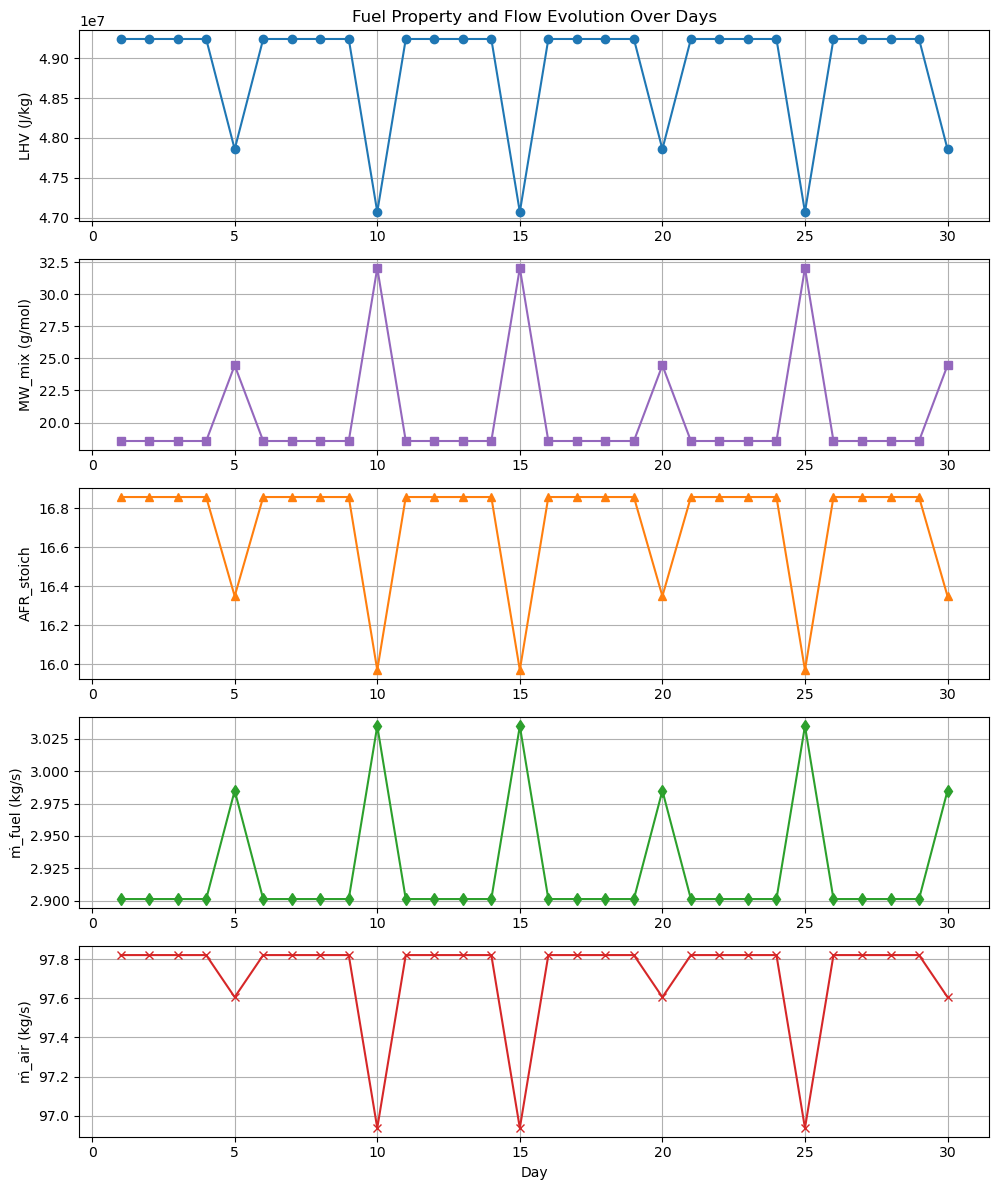

In [27]:
df = df_results

plt.figure(figsize=(10, 12))

# LHV
plt.subplot(5, 1, 1)
plt.plot(df["Day"], df["LHV_mix (J/kg)"], "o-", color="tab:blue")
plt.ylabel("LHV (J/kg)")
plt.title("Fuel Property and Flow Evolution Over Days")
plt.grid(True)

# MW
plt.subplot(5, 1, 2)
plt.plot(df["Day"], df["MW_mix (g/mol)"], "s-", color="tab:purple")
plt.ylabel("MW_mix (g/mol)")
plt.grid(True)

# AFR_stoich
plt.subplot(5, 1, 3)
plt.plot(df["Day"], df["AFR_stoich (kg_air/kg_fuel)"], "^-", color="tab:orange")
plt.ylabel("AFR_stoich")
plt.grid(True)

# Fuel mass flow
plt.subplot(5, 1, 4)
plt.plot(df["Day"], df["m_dot_fuel (kg/s)"], "d-", color="tab:green")
plt.ylabel("ṁ_fuel (kg/s)")
plt.grid(True)

# Air mass flow
plt.subplot(5, 1, 5)
plt.plot(df["Day"], df["m_dot_air (kg/s)"], "x-", color="tab:red")
plt.ylabel("ṁ_air (kg/s)")
plt.xlabel("Day")
plt.grid(True)

plt.tight_layout()
plt.show()

| Composition Type  | CH₄ (%) | C₂H₆ (%) | C₃H₈ (%) | C₄H₁₀ (%) | C₅H₁₂ (%) | LHV_mix (MJ/kg) | MW_mix (g/mol) | AFR_stoich (kg_air/kg_fuel) | ṁ_fuel (kg/s) | ṁ_air (kg/s) |
| ----------------- | ------- | -------- | -------- | --------- | --------- | --------------- | -------------- | --------------------------- | -------------- | ------------- |
| **Natural Gas**   | 90      | 5        | 3        | 1         | 1         | **49.24**       | 18.57          | **16.86**                   | **2.90**       | **97.82**     |
| **Butane Spike**  | 76      | 5        | 3        | 15        | 1         | **47.86**       | 24.46          | **16.35**                   | **2.98**       | **97.61**     |
| **Pentane Spike** | 66      | 5        | 3        | 1         | 25        | **47.07**       | 32.03          | **15.97**                   | **3.03**       | **96.94**     |


**Impact of Pentane and Butane spikes on Combustion and Autoignition**

**Molecular Weight $MW_{mix}$**

The rise in heavier hydrocarbons (Butane, Pentane) → larger molecular weight (C₄–C₅)
→ Increases $MW_{mix}$ (18.6 → 32 g/mol)
→ Produces denser, and more chemically reactive mixtures that burns slower.

---
**Lower $LHV_{mix}$**

Decrease in **Lower Heating Value** (LHV_mix)
→ Decreases from 49.24 to 47.86 and 47.07 MJ/kg
→ Less energy per unit mass → turbine requires slightly more fuel to sustain 60 MW
→ Rise in **fuel mass flow rate** (ṁ_fuel, 2.90 → 2.98 and 3.03 kg/s)

---
**$AFR_{stoich}$**

Decrease in stoichiometric **Air–Fuel Ratio** (AFR_stoich)
→ Falls from 16.9 → 16.0 kg_air/kg_fuel
→ For the same **excess air factor (λ = 2.0)**, the **local equivalence ratio** can change and potentially create **rich zones** inside the premixer.  
→ Richer regions → **higher local flame temperatures** → **faster radical formation** → **greater likelihood of premature ignition**.

---
**$\dot{m}_{air}$**

- **Decreases slightly** from **~97.8 → 97.6 → 96.9 kg/s** as heavier hydrocarbons reduce the air required per kilogram of fuel (they have a higher energy and atoms per molecule ratio, so less air mass is needed per kilogram of fuel to fully oxidize all carbon and hydrogen).  
- Even though the turbine maintains the same power output, this can create **non-uniform air–fuel distributions**, amplifying **local ignition risks**.

---
**$\dot{m}_{fuel}$**

Increase in **fuel mass flow** (2.901 → 2.985 and 3.035 kg/s)
Because during spikes, the turbine needs to inject more fuel to maintain the same power because the HHCs have slightly lower LHV per kg than methane.
→ Richer mix because the air flow does not increase proportionally (it actually decreases during the spikes)
→ Creates richer fuel-air pockets in the premixer
→ May increase local temperatures because there is more available fuel to release energy
→ Increased risk of autoignition.

### Part II: Sensitivity to Chemical Mechanism

#### Introduction

We previously computed the ignition delays and focused on the different fuel compositions as well as their impact on the delays. In this part, we will focus on the impact of different chemical mechanisms on these delays. 

#### Methodology

We will simulate the ignition delays in the same manner as in the previous part for the following chemical mechanisms : NUIG 1.3, ARAMCO 3 and CRECK (C3MechLite). However, as pentane is not found in ARAMCO 3, we will lump all the higher hydrocarbons into the highest one this mechanism can accomodate. We will then discuss the impact of the lumping. The NUIG 1.3 and CRECK mechanisms, which include n-pentane (NC5H12), will be used for comparison.

In [4]:
import cantera as ct
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py

In [ ]:
# Chosen Parameters

P_bar = 40.0
T_preheat = 890.0
phi = 0.625
res_time_range_ms = (2, 20)
max_sim_time = 0.1
oxidizer = {"O2": 1, "N2": 3.76}

In [ ]:
# Mechanisms

mechanisms = {
    "NUIG 1.3": "nuig_3005.yaml",
    "ARAMCO 3": "aramco3.yaml",
    "CRECK (C3MechLite)": "CRECK_2003_TOT_HT_LT.yaml",
}

In [ ]:
# Read composition file 

fuel_data = pd.read_csv("fuel_composition.csv")
fuel_columns = fuel_data.columns[1:]
fuel_data[fuel_columns] /= 100.0

In [ ]:
# Select representative days (Natural gas, pentane spike, butane spike)

def get_day_fuel(day):
    row = fuel_data[fuel_data["Day"] == day].iloc[0]
    return {
        "CH4": row["Methane"],
        "C2H6": row["Ethane"],
        "C3H8": row["Propane"],
        "C4H10": row["Butane"],
        "NC5H12": row["Pentane"],
    }

fuel_cases = {
    "Pentane Spike": get_day_fuel(10),
    "Butane Spike": get_day_fuel(5),
    "Natural Gas": get_day_fuel(1),
}

cached_mechs = {name: ct.Solution(path) for name, path in mechanisms.items()}

In [ ]:
# Functions

def adapt_fuel_for_mechanism(gas, base_fuel):
    """Lump species not present in mechanism (e.g. NC5H12 -> C4H10)."""
    species = gas.species_names
    fuel_dict = {}
    for sp, val in base_fuel.items():
        if val <= 0:
            continue
        if sp in species:
            fuel_dict[sp] = val
        elif sp == "NC5H12":
            if "C4H10" in species:
                fuel_dict["C4H10"] = fuel_dict.get("C4H10", 0.0) + val
            elif "C3H8" in species:
                fuel_dict["C3H8"] = fuel_dict.get("C3H8", 0.0) + val
            else:
                fuel_dict["CH4"] = fuel_dict.get("CH4", 0.0) + val
    return fuel_dict


def ignition_delay(gas, fuel_dict):
    """Compute ignition delay for given mechanism and fuel."""
    gas.TP = T_preheat, P_bar * 1e5
    gas.set_equivalence_ratio(phi, fuel_dict, oxidizer)
    r = ct.IdealGasConstPressureMoleReactor(gas)
    sim = ct.ReactorNet([r])
    T_init = r.T
    t = 0.0

    while t < max_sim_time:
        t = sim.step()
        if (r.T - T_init) > 400:  # ignition criterion
            ignition_time = t * 1000  # ms
            break
    else:
        ignition_time = np.nan

    return ignition_time

In [ ]:
# Ignition simulation

results = []

for mech_name, gas in cached_mechs.items():
    for case_name, fuel_dict in fuel_cases.items():
        adapted_fuel = adapt_fuel_for_mechanism(gas, fuel_dict)
        tau_ms = ignition_delay(gas, adapted_fuel)

        if np.isnan(tau_ms):
            risk = "No ignition"
        elif tau_ms <= res_time_range_ms[1]:
            risk = "Possible autoignition (τ ≤ 20 ms)"
        else:
            risk = "No autoignition (τ > 20 ms)"

        results.append({
            "Mechanism": mech_name,
            "Case": case_name,
            "Ignition Delay (ms)": tau_ms,
            "Risk": risk
        })

# Results
df_results_all = pd.DataFrame(results)
df_results_all.to_csv("ignition_mechanism_comparison_all_cases.csv", index=False)
print(df_results_all)

In [2]:
# Plot

colors = {"Pentane Spike": "red", "Butane Spike": "orange", "Natural Gas": "blue"}
symbols = {"Pentane Spike": "circle", "Butane Spike": "diamond", "Natural Gas": "square"}

traces = []
for case_name in df_results_all["Case"].unique():
    subset = df_results_all[df_results_all["Case"] == case_name]
    trace = go.Scatter(
        x=subset["Mechanism"],
        y=subset["Ignition Delay (ms)"],
        mode="markers+lines+text",
        name=case_name,
        text=subset["Ignition Delay (ms)"].round(2),
        textposition="top center",
        marker=dict(color=colors[case_name], symbol=symbols[case_name], size=12),
    )
    traces.append(trace)

layout = go.Layout(
    title="Ignition Delay vs Mechanism for Different Fuel Compositions",
    xaxis=dict(title="Mechanism"),
    yaxis=dict(title="Ignition Delay (ms)", type="log"),
    width=900,
    height=600,
    paper_bgcolor="white",
    plot_bgcolor="white",
    showlegend=True,
)

fig = go.Figure(data=traces, layout=layout)
py.iplot(fig)

            Mechanism           Case  Ignition Delay (ms)  \
0            NUIG 1.3  Pentane Spike             2.785712   
1            NUIG 1.3   Butane Spike             9.356303   
2            NUIG 1.3    Natural Gas            26.013779   
3            ARAMCO 3  Pentane Spike            11.083204   
4            ARAMCO 3   Butane Spike            14.662690   
5            ARAMCO 3    Natural Gas            34.771269   
6  CRECK (C3MechLite)  Pentane Spike             5.714775   
7  CRECK (C3MechLite)   Butane Spike            35.652791   
8  CRECK (C3MechLite)    Natural Gas            37.557317   

                                Risk  
0  Possible autoignition (τ ≤ 20 ms)  
1  Possible autoignition (τ ≤ 20 ms)  
2        No autoignition (τ > 20 ms)  
3  Possible autoignition (τ ≤ 20 ms)  
4  Possible autoignition (τ ≤ 20 ms)  
5        No autoignition (τ > 20 ms)  
6  Possible autoignition (τ ≤ 20 ms)  
7        No autoignition (τ > 20 ms)  
8        No autoignition (τ > 20 ms)  

#### Results and Discussions

**Premixer & Probability Assumptions**
- Residence time: **2–20 ms**, assumed **uniform distribution**.  
- Autoignition probability for a fuel pocket:  

$$
P(\text{autoignition}) =
\begin{cases}
1, & \tau \le 2 \text{ ms} \\
\dfrac{20 - \tau}{18}, & 2 < \tau < 20 \\
0, & \tau \ge 20
\end{cases}
$$

| Mechanism | Case | τ (ms) | Autoignition Probability |
|-----------|------|--------|-------------------------|
| NUIG 1.3 | Pentane spike | 2.79 | 95.6% → almost certain |
| NUIG 1.3 | Butane spike  | 9.36 | 59.1% → moderate risk |
| NUIG 1.3 | Natural gas    | 26.01 | 0% → safe |
| ARAMCO 3 | Pentane spike  | 11.08 | 49.5% → moderate risk |
| ARAMCO 3 | Butane spike   | 14.66 | 29.7% → low-moderate risk |
| ARAMCO 3 | Natural gas    | 34.77 | 0% → safe |
| CRECK     | Pentane spike | 5.71 | 79.4% → high risk |
| CRECK     | Butane spike  | 35.65 | 0% → safe |
| CRECK     | Natural gas    | 37.56 | 0% → safe |

---

**Mechanism Sensitivity & Analysis**

- **NUIG 1.3**
  - Explicitly includes **C₄–C₅ hydrocarbons** (n- and iso-isomers).  
  - Captures **low-temperature chain branching**:
    - RO₂ → QOOH → ketohydroperoxide (KHP) + OH → rapid radical production → short τ.
    - Coherent with the values: Pentane spike τ = **2.79 ms**, Butane spike τ = **9.36 ms**.
  - Predicts shortest τ → **highest autoignition probability** → closest to real DLE behavior.  

- **ARAMCO 3**
  - **Lumps heavy hydrocarbons** (C₄–C₅) into lighter surrogates.  
  - Low-temperature oxidation pathways are simplified or removed → fewer radicals generated, slower chain branching → longer τ.
  - Observed values: Pentane spike τ = **11.08 ms**, Butane spike τ = **14.66 ms**.
  - **Underpredicts autoignition risk** because lumping omits the RO₂ → QOOH → KHP loops important for C₄–C₅ reactivity.

- **CRECK (C3MechLite)**
  - Reduced mechanism optimized for **C₁–C₃ chemistry**.  
  - **Pentane spike τ = 5.71 ms**: pentane is extremely reactive; even reduced C₁–C₃ chemistry captures short ignition delay → relatively accurate.  
  - **Butane spike τ = 35.65 ms**: low-temperature pathways for C₄ species are mostly absent → τ overestimated → autoignition probability underestimated.  
  - τ(NG) = **37.56 ms** > τ(Butane) = **35.65 ms** >> τ(Pentane) = **5.71 ms**.  
  - CRECK is better than ARAMCO for pentane (highly reactive, short τ), but fails for butane (moderately reactive, low-T chemistry missing).

> Lumping or reducing C₄–C₅ chemistry removes **low-temperature RO₂–QOOH–KHP loops**, which dominate ignition at 850–900 K. Without them, mechanisms **overestimate τ** → underestimate in-premixer autoignition probability.

---

**Best Mechanism**
- **NUIG 1.3** is best suited for this application:
  - Explicitly treats C₄–C₅ hydrocarbons and isomers.  
  - Captures **low-temperature chain-branching chemistry** → accurate τ predictions.  
  - Reliable assessment of **autoignition probability** for pentane/butane spikes.  
- **Avoid lumped/reduced mechanisms** (ARAMCO 3, CRECK).

---

**Summary**
- Low-temperature oxidation loops (RO₂ → QOOH → KHP + OH) are **critical for heavy hydrocarbon reactivity**.  
- Mechanism choice strongly affects predicted autoignition probability:  
  - **NUIG 1.3** gives the most accurate predictions.  
  - **CRECK** is acceptable for highly reactive pentane, but fails for butane.  
  - **ARAMCO 3** consistently underestimates risk due to lumping.  

## Effect of air staging for aero-derivative turbine

### Part I 

#### Introduction

The goal of this part is to study the effect of air staging (here modelized by an 0D perfectly stirred model) on the emissions of pollutants (CO, NOX, UHC...) for an aero-derivative turbine. 
In this study, we investigate the combustion behavior of methane–air mixtures in an aero-derivative gas turbine combustor under high-pressure conditions.  

The objective is to understand how the combustor behaves under realistic residence times and staging configurations, and how pollutant emissions (CO, NOₓ, unburned CH₄) are influenced by combustion completeness.

#### Methodology

Let's calculate the required mass flow rate of methane at full load:

$$
\dot{m}_{\text{methane}} = \dot{m}_{\text{fuel}} = \frac{P_{\text{out}}}{\eta \cdot LHV} = \frac{140}{0.45 \cdot 50} \approx 6.22~\text{kg/s}
$$

Let's now compute the overall equivalence ratio:

$$
\phi = \frac{(F/A)}{(F/A)_{\text{stoich}}}
$$
Where $F/A$ is the mass ratio of fuel to air.  


It becomes :

$$
\phi = \frac{\dot{m}_\text{fuel} / \dot{m}_\text{air}}{1/AFR_{\text{stoich}}} = \frac{\dot{m}_\text{methane}}{\dot{m}_\text{air}} \cdot AFR_{\text{stoich}}
$$


Let's find the **Stoichiometric Air To Fuel Ratio**.
First, let's find the mass ratio of fuel for **methane (CH₄) burning in air**.


The stoichiometric combustion reaction for CH₄ burning in air is 
$$
\ce{CH4 + 2 O2 + 7.52 N2 -> CO2 + 2 H2O + 7.52 N2}
$$

- Air is composed of O₂ and N₂ with a mole ratio $N_2/O_2 \approx 3.76$.  
- 1 mole of CH₄ requires 2 moles of O₂. The nitrogen is inert.

---


$$
AFR_{\text{stoich}} = \frac{\text{mass of air required}}{\text{mass of fuel}}
$$

The **mass of air** is :

$$
\begin{aligned}
M_{\ce{O2}} &= 32~\mathrm{g/mol} \\
M_{\ce{N2}} &= 28~\mathrm{g/mol} \\
m_\text{air} &= 2 \cdot 32 + 7.52 \cdot 28 \\
m_\text{air} &= 64 + 210.56 = 274.56~\mathrm{g}
\end{aligned}
$$

The **mass of methane** is :

$$
m_\text{methane} = 16~\mathrm{g/mol} * 1 mol
$$

Hence, we get the **stoichiometric air-fuel ratio** :

$$
AFR_{\text{stoich}} = \frac{274.56}{16} \approx 17.16
$$



We already know $\dot{m}_\text{methane} \approx 6.22 \mathrm{kg/s}$ and $\dot{m}_\text{air} \approx 220 \mathrm{kg/s}$

Finally, 

$$
\phi = \frac{\dot{m}_\text{methane}}{\dot{m}_\text{air}} \cdot AFR_{\text{stoich}} = \frac{6.22}{220} \cdot 17.16 \approx 0.485
$$

The system is globally lean ($\phi < 1$)


We can now calculate $\tau_{res}$, the *residence time*. 

The aero-derivative turbine "burns gaseous fuels like natural gas" -> PV = nRT -> $\rho = \frac{P}{RT} = \frac{35*101325}{287.05*850} \approx 14.53 kg/m^3$.

The total mass rate is $\dot{m}_\text{tot} = \dot{m}_\text{air} + \dot{m}_\text{methane} \approx 226.22kg/s$.

Thus, $\dot{V} = \frac{\dot{m}_\text{tot}}{\rho} \approx \frac{226.22}{14.53} \approx 15.57 m^3/s$.

Finally, $\tau_{res} = \frac{V_{comb}}{\dot{V}} \approx \frac{0.3}{15.57} \approx 19.27ms$

In [2]:
# Parameters
P_out = 140e6         # W
eta = 0.45
mdot_air = 220.0      # kg/s (fixed by compresser)
V_comb = 0.3          # m^3
P = 35.0 * ct.one_atm # Pa
T_in = 850.0          # K
LHV = 50e6            # J/kg 

In [3]:
# Compute mdot_methane, phi, rho and tau_res

mdot_methane = P_out / (eta * LHV)       # kg/s
mdot_total = mdot_air + mdot_methane

M_methane = 16  # g/mol
M_O2      = 32  # g/mol
M_N2      = 28  # g/mol
m_air = 2 * M_O2 + 7.52 * M_N2 # g
m_methane = M_methane * 1      # g
AFR_stoich = m_air / m_methane
phi = (mdot_methane / mdot_air) * AFR_stoich

M_air = 28.97     # kg/kmol
R = ct.gas_constant / M_air  # J/(kg K)
rho = P / (R * T_in)
Vdot = mdot_total / rho
tau_res = V_comb / Vdot

print(f"mdot_fuel = {mdot_methane:.5f} kg/s")
print(f"Equivalence ratio phi = {phi:.4f}")
print(f"Total mass flow = {mdot_total:.4f} kg/s")
print(f"Density (ideal-gas approx) = {rho:.4f} kg/m3")
print(f"Volumetric flow Vdot = {Vdot:.4f} m3/s")
print(f"Residence time tau = {tau_res:.6f} s = {tau_res*1e3:.3f} ms")

mdot_fuel = 6.22222 kg/s
Equivalence ratio phi = 0.4853
Total mass flow = 226.2222 kg/s
Density (ideal-gas approx) = 14.5372 kg/m3
Volumetric flow Vdot = 15.5616 m3/s
Residence time tau = 0.019278 s = 19.278 ms


In [4]:
# Inlet composition (CH4-air mixture)

n_air = mdot_air / M_air              # kmol/s
n_methane = mdot_methane / M_methane  # kmol/s
n_O2 = 0.21 * n_air
n_N2 = 0.79 * n_air
n_total = n_O2 + n_N2 + n_methane
X_in = {'CH4': n_methane / n_total, 'O2': n_O2 / n_total, 'N2': n_N2 / n_total}
print("Inlet composition:", X_in)

Inlet composition: {'CH4': 0.04871492436562977, 'O2': 0.1997698658832177, 'N2': 0.7515152097511524}


In [7]:
# Adiabatic equilibrium

gas_equil = ct.Solution('grimech30.yaml') # Includes NO specie

In [8]:
gas_equil.TPX = T_in, P, X_in
gas_equil.equilibrate('HP') # Calculate equilibrium at HP: Enthalpy H and Pressure P constant
T_eq = gas_equil.T

X = gas_equil.X

X_CO_eq  = X[gas_equil.species_index('CO')]
X_NO_eq  = X[gas_equil.species_index('NO')]
X_NO2_eq = X[gas_equil.species_index('NO2')] 
X_N2O_eq = X[gas_equil.species_index('N2O')]
X_CH4_eq = X[gas_equil.species_index('CH4')]
X_NOx_eq = X_NO_eq + X_NO2_eq + X_N2O_eq

print("Adiabatic equilibrium")
print(f"T_eq = {T_eq:.2f} K")
print(f"CO (mole frac) = {X_CO_eq:.6e}")
print(f"NO (mole frac) = {X_NO_eq:.6e}")
print(f"NOx (NO+NO2+N2O) (mole frac) = {X_NOx_eq:.6e}")
print(f"CH4 (mole frac) = {X_CH4_eq:.6e}")

Adiabatic equilibrium
T_eq = 1902.37 K
CO (mole frac) = 1.455666e-05
NO (mole frac) = 3.907188e-03
NOx (NO+NO2+N2O) (mole frac) = 3.941368e-03
CH4 (mole frac) = 5.974048e-24


In [9]:
gas_psr = ct.Solution('grimech30.yaml')
gas_psr.TPX = T_in, P, X_in

In [ ]:
gas_psr.species_names

In [10]:
# IdealGasReactor with given volume and computed tau 

# Initialize the reactor with constant volume 
psr = ct.IdealGasReactor(gas_psr, energy='on', volume=V_comb)
# Upstream reservoir with air + cold fuel
upstream = ct.Reservoir(gas_psr)
# Downstream reservoir initialized at the same state as the inlet
downstream = ct.Reservoir(gas_psr)

# Mass controller mdot = mass in the reactor / tau
mfc = ct.MassFlowController(upstream, psr, mdot=psr.mass / tau)
valve = ct.Valve(psr, downstream, K=0.01)

# Reactor network
net = ct.ReactorNet([psr])

# Advance to steady state
t = 0.0
net.advance_to_steady_state()

X_psr = psr.thermo.X
X_CO_psr = psr.thermo['CO'].X[0]
X_NO_psr = psr.thermo['NO'].X[0] + psr.thermo['NO2'].X[0] + psr.thermo['N2O'].X[0]
X_CH4_psr = psr.thermo['CH4'].X[0]

print("=== PSR steady-state (tau = {:.6e} s) ===".format(tau_res))
print("Reactor steady-state T = {:.2f} K, P = {:.2f} atm".format(psr.T, psr.thermo.P/ct.one_atm))
print(f"T_psr = {psr.T:.2f} K")
print(f"CO (mole frac) = {X_CO_psr:.6e}")
print(f"NOx (mole frac) = {X_NO_psr:.6e}")
print(f"CH4 (mole frac) = {X_CH4_psr:.6e}")
print("========================================\n")


=== PSR steady-state (tau = 1.927818e-02 s) ===
Reactor steady-state T = 850.00 K, P = 35.22 atm
T_psr = 850.00 K
CO (mole frac) = 6.729146e-09
NOx (mole frac) = 7.258392e-14
CH4 (mole frac) = 4.871432e-02



**Adiabatic equilibrium results**

**Cantera simulation** (`gas.equilibrate('HP')`) produced:

|  |  |  |  |  |
|-----------|---------|--------|--------------|----------------|
| Temperature | $T_{eq}$ | **1902 K** | — | Adiabatic flame temp |
| CO (mole fraction) | 1.46×10⁻⁵ | **≈ 14.6 ppm** | Almost complete oxidation |
| NOx (mole fraction) | 3.94×10⁻³ | **≈ 3,940 ppm** | High thermal NO formation |
| CH₄ (mole fraction) | 5.97×10⁻²⁴ | ~0 ppm | Fully burned fuel |

This represents the **thermodynamic limit** of complete combustion with no kinetic constraints: infinite time, perfect mixing and adiabatic conditions.  
In such a scenario, the mixture has reached full equilibrium, most of the fuel turns into CO₂ and H₂O, with very little pollution produced.  
The 1902 K flame temperature is consistent with lean methane-air combustion at 35 atm (see Turns, *An Introduction to Combustion*, 3rd ed., 2012).

---

**Perfectly Stirred Reactor (PSR)**


|  |  |  |  |  |
|-----------|---------|--------|--------------|----------------|
| Reactor temperature | $T_{psr}$ | **850 K** | Isothermal condition |
| CO (mole fraction) | 6.73×10⁻⁹ | **≈ 0.007 ppm** | Negligible |
| NOx (mole fraction) | 7.26×10⁻¹⁴ | **≈ 0 ppm** | Negligible |
| CH₄ (mole fraction) | 4.87×10⁻² | **≈ 48,700 ppm (4.9%)** | Significant unburned fuel (UHC) |

**The mixture did not ignite** due to low T and short residence time.  

---

|  | Adiabatic Equilibrium | PSR (Isothermal, 850 K) | Physical Meaning |
|--------|------------------------|--------------------------|------------------|
| Temperature | 1902 K | 850 K | Determines reaction rate and NOx formation |
| CH₄ | ~0 ppm | 4.9% | Large unburned hydrocarbon fraction |
| CO | 15 ppm | ~0 ppm | Reaction incomplete, but CO suppressed |
| NOx | 3,940 ppm | ~0 ppm | Thermal NOx formation needs high T |
| Residence time | N/A | 19 ms | Flow too fast for complete kinetics |

The equilibrium predicts the **max possible NOx** and **min CO / UHC**.
The PSR is kinetically limited → unburned CH₄ ≈ 5% and negligible NOx/CO. The mixture is well mixed but not sufficiently reactive to reach equilibrium within the residence time.

---

With our calculated $\tau$, the system does not have time to ignite. Let's **sweep values of $\tau$**. 

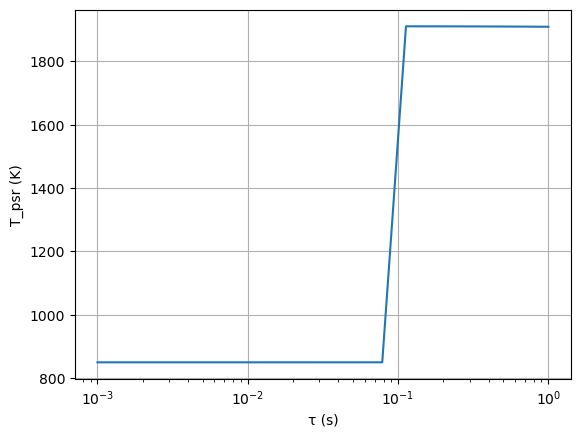

In [11]:
taus = np.logspace(-3, 0, 20)  # de 1 ms à 1 s
T_psr_list = []

for tau in taus:
    gas_psr.TPX = T_in, P, X_in
    psr = ct.IdealGasReactor(gas_psr, energy='on', volume=V_comb)
    upstream = ct.Reservoir(gas_psr)
    downstream = ct.Reservoir(gas_psr)
    mfc = ct.MassFlowController(upstream, psr, mdot=psr.mass / tau)
    valve = ct.Valve(psr, downstream, K=0.01)
    net = ct.ReactorNet([psr])
    net.advance_to_steady_state()
    T_psr_list.append(psr.T)

import matplotlib.pyplot as plt
plt.semilogx(taus, T_psr_list)
plt.xlabel('τ (s)')
plt.ylabel('T_psr (K)')
plt.grid(True)
plt.show()


- **Low plateau (~850 K) for small τ:**  
  → No ignition occurs.  
  → Reaction rates are extremely slow, and the radical pool is insufficient to sustain combustion.

- **Sharp temperature rise around a critical τ ($τ_{crit}$ ≈ 0.08 s):**  
  → Transition to a **runaway exothermic state**.  
  → Chemical heat release exceeds heat losses, leading to a rapid temperature increase.

- **High plateau (~T_ad ≈ adiabatic flame temperature):**  
  → Fully burned (combusted) mixture.  
  → System reaches near-adiabatic equilibrium conditions.

The calculated residence time (τ = **0.019 s**) is **below the critical ignition residence time** ($τ_{crit} ≈ **0.08 s**$).  
→ It is therefore **expected** that no significant temperature rise occurs at τ = 0.019 s.

---

- The mixture is **quite lean (ϕ ≈ 0.485)** → lower reactivity → **longer ignition delay**.  
- Although the pressure is high (which accelerates reaction rates), the **inlet temperature (850 K)** is still too low to trigger fast ignition chemistry.  
- Hence, at τ = 0.019 s, the system leaves the combustor **before ignition reactions can develop**.

---

| Region | τ Behavior | Temperature | Combustion State |
|--------|--------------------|--------------|------------------|
| τ < $τ_{crit}$ (~0.08 s) | Slow kinetics, no ignition | ~850 K | Unreacted / lean mixture |
| τ ≈ $τ_{crit}$ | Rapid T rise | 850 → 1900 K | Ignition transition |
| τ > $τ_{crit}$ | Fully developed burn | $T_{ad}$ (~1900 K) | Near-equilibrium |

The combustor’s nominal residence time (**0.019 s**) lies in the **non-ignited regime**, so the low PSR temperature (850 K) and high unburned CH₄ fraction are coherent.

---


Let's determine what residence time choose to minimise CO and NOx.

We want two thresholds as functions of reactor residence time τ:

1. **$τ_{CO,min}$** : the *minimum* residence time after which the reactor outlet CO concentration **exceeds 25 ppm (by volume)**.  
   - Early in τ the chemistry is too slow and very little CO forms; as τ increases, partial oxidation pathways produce more CO before full oxidation consumes it. This threshold is the first τ where $X_{CO} * 1e6 > 25$.

2. **$τ_{NOx,max}$** : the *maximum* residence time that still keeps NOx (NO+NO₂+N₂O) **≤ 25 ppm**. Equivalently, it's the τ at which NOx first exceeds 25 ppm as τ increases.  
   - As τ increases, the reactor temperature typically rises toward the adiabatic equilibrium temperature and thermal NOx production increases; thus, NOx tends to grow with τ.

We will scan τ over a wide range, record steady-state mole fractions from a PSR (IdealGasReactor), and find the crossing points numerically.

---

In [38]:
import matplotlib.pyplot as plt
from math import isclose

In [39]:
# Parameters

tau_min_scan = 1e-4          
tau_max_scan = 5.0           
n_scan = 120                 
tol_bisect = 1e-6            # bisector tolerance (s)
max_bisect_iter = 60

# thresholds (ppm)
ppm_threshold = 25.0

In [70]:
mech = 'grimech30.yaml'
gas = ct.Solution(mech)

gas.TPX = T_in, P, X_in

In [71]:
# Function to compute CO & NOx for a given tau
def run_psr(tau):
    # Reset gas state each iteration
    gas.TPX = T_in, P, X_in
    upstream = ct.Reservoir(gas)
    downstream = ct.Reservoir(gas)
    
    psr = ct.IdealGasReactor(gas, energy='on', volume=V_comb)  # reset the reactor to inlet
    net = ct.ReactorNet([psr])
    # Mass flow rate and controllers
    mdot = psr.mass / tau
    mfc = ct.MassFlowController(upstream, psr, mdot=mdot)
    valve = ct.Valve(psr, downstream, K=0.01)
    
    # Run to steady state
    net.advance_to_steady_state()
    
    # Extract species mole fractions
    X = psr.thermo.X
    species = psr.thermo.species_names
    idx = {sp: i for i, sp in enumerate(species)}

    X_CO = X[idx['CO']] if 'CO' in idx else 0.0
    X_NO = X[idx['NO']] if 'NO' in idx else 0.0
    X_NO2 = X[idx['NO2']] if 'NO2' in idx else 0.0
    X_N2O = X[idx['N2O']] if 'N2O' in idx else 0.0
    X_NOx = X_NO + X_NO2 + X_N2O

    return psr.T, X_CO * 1e6, X_NOx * 1e6  # convert to ppmv

In [72]:
# Range of residence times

taus = np.logspace(-3, 1, 40)  # from 1 ms to 10 s
CO_ppm = np.zeros_like(taus)
NOx_ppm = np.zeros_like(taus)
T_out = np.zeros_like(taus)

In [73]:
# Sweep residence time

for i, tau in enumerate(taus):
    T_out[i], CO_ppm[i], NOx_ppm[i] = run_psr(tau)

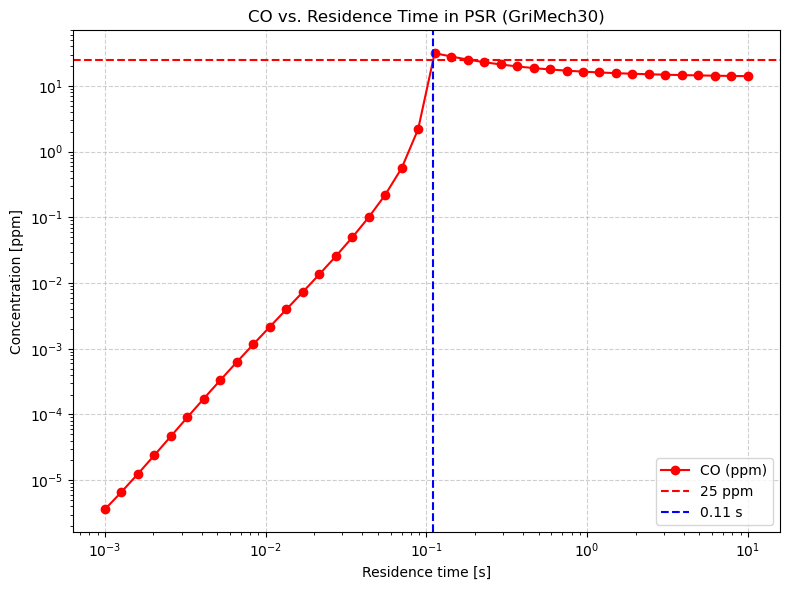

In [85]:
plt.figure(figsize=(8,6))
plt.loglog(taus, CO_ppm, 'r-o', label='CO (ppm)')

plt.axhline(y=25, color='r', linestyle='--', label='25 ppm')
plt.axvline(x=0.11, color='b', linestyle='--', label='0.11 s')

plt.xlabel('Residence time [s]')
plt.ylabel('Concentration [ppm]')
plt.title('CO vs. Residence Time in PSR (GriMech30)')
plt.grid(True, ls='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

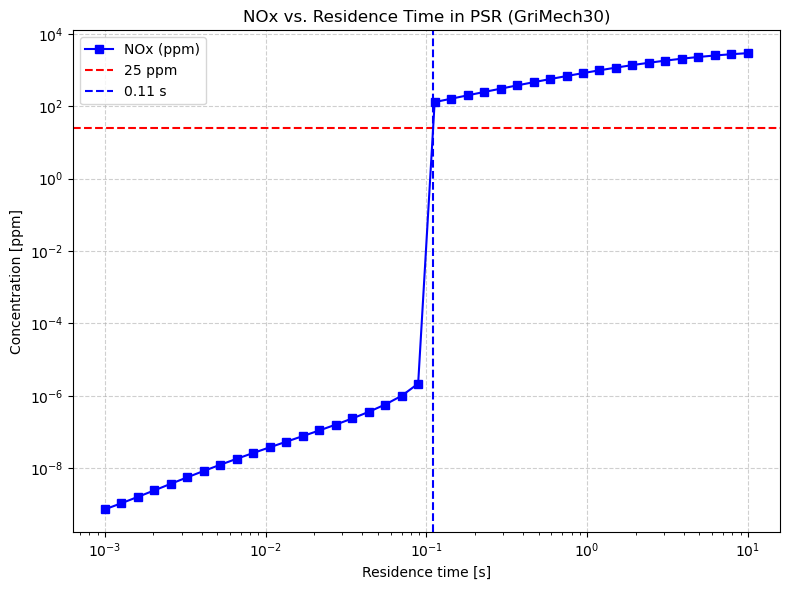

In [84]:
plt.figure(figsize=(8,6))
plt.loglog(taus, NOx_ppm, 'b-s', label='NOx (ppm)')

plt.axhline(y=25, color='r', linestyle='--', label='25 ppm')
plt.axvline(x=0.11, color='b', linestyle='--', label='0.11 s')

plt.xlabel('Residence time [s]')
plt.ylabel('Concentration [ppm]')
plt.title('NOx vs. Residence Time in PSR (GriMech30)')
plt.grid(True, ls='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

**CO**

- **τ = 10⁻³ – 0.08 s:** CO increases quasi-linearly from ~3.5×10⁻⁶ ppm to ~2 ppm.
- **τ ≈ 0.1 s:** Sudden jump in CO concentration (~20 ppm).
- **τ > 1 s:** Slight decrease and stabilization around ~15 ppm.

- **Short τ (<0.1 s) → kinetically limited combustion**  
  - Incomplete conversion of CH₄ → CO₂ + H₂O.  
  - CO accumulates slowly as partial oxidation occurs.  
  - Highlights the **importance of sufficient residence time for complete combustion**.

- **Transition (~0.1 s) → radical buildup**  
  - Rapid CO increase indicates that CH₄ is partially oxidized, but CO → CO₂ reactions lag.  
  - Sensitive region for **reaction kinetics and mixing efficiency**.

- **Long τ (>1 s) → quasi-equilibrium**  
  - CO stabilizes as CH₄ conversion approaches steady-state.  
  - Indicates the **upper limit of CO reduction achievable in this PSR volume**.

---

**NOx**

- **τ = 10⁻³ – 0.09 s:** NOx nearly zero (2×10⁻⁹ → 2×10⁻⁶ ppm).  
- **τ ≈ 0.1 s:** Large jump to ~100 ppm.  
- **τ > 7 s:** Slight growth and stabilization around ~2000 ppm.

- **Short τ → negligible NOx**  
  - Temperature insufficient for thermal NO formation.  
  - CO dominates, NOx minimal.

- **Transition (~0.1 s) → onset of thermal NOx**  
  - Large jump in NOx as radicals and O atoms now sufficient to convert N₂ → NO.  
  - **CO-NOx trade-off**.

- **Long τ (>7 s) → quasi-equilibrium**  
  - Thermal NOx approaches maximum given the inlet temperature and mixture.  
  - Extending τ further does not reduce NOx → **thermodynamic limit**.

---

**Trade-offs and design considerations:**

- **CO decreases / NOx increases** as τ increases:  
Short τ → incomplete combustion → CO high, NOx low

Intermediate τ → CO decreases, NOx rises sharply

Long τ → CO low, NOx very high

The **Air Staging Concept** (injecting a portion of the combustion air after the primary combustion zone rather than all at the inlet) would reduce peak flame temperature in the primary zone to limit NOx formation while still ensuring complete combustion.  
In our scenario, the primary zone has short τ, limited NOx formation and moderate CO. The secondary air injection raises O₂ availability without increasing local flame temperature, to allow CO conversion to CO₂ without spiking NOx.

**Optimal τ selection:**  
- For an aero-derivative GT at 35 atm and $T_{in} ~850 K$:  
  - τ ~ 0.10 s to reduce CO but avoid large NOx rise. 

**Comparison of PSR and Equilibrium Concentrations for CO₂ and NOx**

- **Equilibrium (adiabatic) values** at T_in = 850 K and P = 35 atm:
  - CO₂ is nearly at its maximum possible mole fraction (CH₄ fully oxidized).  
  - CO is essentially zero (~10⁻⁵–10⁻⁶).  
  - NOx (NO, NO₂, N₂O) is practically zero because the temperature is far below the activation threshold for thermal NOx formation (~1800 K).  
- **PSR values** at the same inlet conditions and τ ~ 0.02 s:
  - CO₂ slightly lower than equilibrium due to incomplete conversion.  
  - CO small but non-zero (~8×10⁻⁶).  
  - NOx remains zero, consistent with equilibrium.  

- The PSR shows **kinetic limitations** that are not captured by equilibrium assumptions.  
- At short residence times, **chemical reactions have not reached completion**, so species like CO and UHC are present even if equilibrium predicts almost none.  
- Equilibrium assumptions **overestimate conversion** of CH₄ → CO₂ and **underestimate transient CO and UHC**.

---

PSR deviates from equilibrium

- **Time scale mismatch:**  
  - PSR accounts for **finite residence time (τ)** in the reactor.  
  - Chemical reactions (CH₄ oxidation, CO oxidation, NO formation) may not reach equilibrium within short τ.
- **Temperature limitation:**  
  - Thermal NOx formation requires **high temperatures (>1800 K)**.  
  - At T_in = 850 K, even infinite τ would not produce much NOx.  
- **Mixing assumption:**  
  - PSR assumes **perfect mixing**, but in reality, staged or partial air injection causes **local gradients**, affecting reaction rates.

---

When to relax the equilibrium assumption

- **Short residence time or high flow rates:**  
  - The reaction time is too low to reach equilibrium.  
  - PSR predicts higher CO and UHC than equilibrium.  
- **Transient operation:**  
  - Equilibrium is never reached during load changes or start-up.  
- **Pollutant control:**  
  - As highlighted in the PSR sweep, equilibrium predictions alone **cannot capture the CO-NOx trade-off** .  

If τ_reactor < τ_chem
→ it's best to use PSR
Else
→ Equilibrium may provide rough estimates

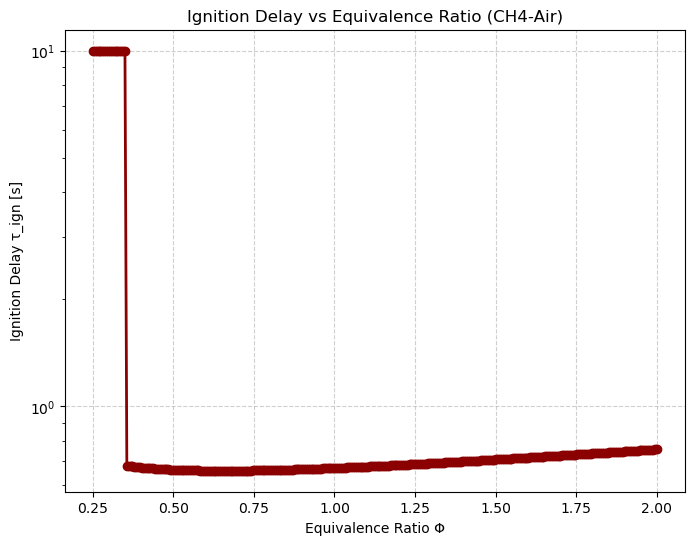

In [1]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

# ------------------- Inputs -------------------
mech = 'grimech30.yaml'        # Mechanism
T_in = 850.0                   # K
P = 35 * ct.one_atm            # Pa
fuel = 'CH4'
oxidizer = 'O2:0.21,N2:0.79'

phi_list = np.linspace(0.25, 2.0, 300)  # equivalence ratios
tau_ign_list = []

# Ignition detection criteria
deltaT_threshold = 400      # K above T_in for ignition
dT_convergence = 0.010      # K, small change in T for convergence
max_time = 10.0             # s, maximum simulation time

# ------------------- Loop over equivalence ratios -------------------
for phi in phi_list:
    # Set mole fractions according to equivalence ratio
    gas = ct.Solution(mech)
    gas.set_equivalence_ratio(phi, fuel, oxidizer)
    gas.TP = T_in, P

    # Create reactor
    r = ct.IdealGasConstPressureMoleReactor(gas, name='R1')
    sim = ct.ReactorNet([r])
    
    # Optional: improve convergence for large mechanisms
    sim.derivative_settings = {"skip-third-bodies": True, "skip-falloff": True}
    sim.preconditioner = ct.AdaptivePreconditioner()
    
    # Initialize time and temperature
    t = 0.0
    t_old = r.T
    tau_ign = max_time

    while t < max_time:
        t = sim.step()
        t_new = r.T
        
        # Check ignition criterion: small ΔT + T above threshold
        if abs(t_new - t_old) < dT_convergence and t_new > T_in + deltaT_threshold:
            tau_ign = t
            break
        
        t_old = t_new

    tau_ign_list.append(tau_ign)

# ------------------- Plot -------------------
plt.figure(figsize=(8,6))
plt.plot(phi_list, tau_ign_list, 'o-', color='darkred', lw=2)
plt.xlabel('Equivalence Ratio Φ')
plt.ylabel('Ignition Delay τ_ign [s]')
plt.title('Ignition Delay vs Equivalence Ratio (CH4-Air)')
plt.grid(True, ls='--', alpha=0.6)
plt.yscale('log')
plt.show()


### Effect of fuel inlet temperature on combustion of aero-derivative combustor

#### Introduction

This part revolves around investigating the effect of fuel inlet temperature on the combustion process of an aero-derivative gas turbine combustor. Whereas the previous simulation assumed all reactants entered at a temperature 850K, here the methane fuel temperature is at 300K. 
Thus, we will calculate the mix temperature and compute the new adiabatic flame temperature and pollutant concentrations.

#### Methodology

Most of the code is similar but with T_fuel = 300K.

In Part 1, both the air and fuel entered at 850 K.  
The mixture was therefore already at a known uniform temperature, so we directly set:

gas.TPX = T_in, P, X_in

which fixes the thermodynamic state completely.

In Part 2, the air (850 K) and fuel (300 K) are mixed before entering the combustor. Because they have different temperatures, the total energy of the mixture must be calculated from the enthalpy balance: 
$$ h_{mix} = \frac{\dot{m}_{air} \cdot h_{air} + \dot{m}_{fuel}\cdot h_{fuel}}{\dot{m}_{air}+\dot{m}_{fuel}} $$
Then, we set the mixture state using H and P and Cantera computes the corresponding temperature.

### Colder fuel 

In [14]:
T_fuel = 300.0

# Mol fractions
X_air = {'O2': 0.21, 'N2': 0.79}
X_fuel = {'CH4': 1.0}

In [15]:
# Gas for enthalpy calculation
gas_air = ct.Solution('grimech30.yaml')
gas_air.TPX = T_air, P, X_air
H_air = gas_air.enthalpy_mass

In [16]:
gas_fuel = ct.Solution('grimech30.yaml')
gas_fuel.TPX = T_fuel, P, X_fuel
H_fuel = gas_fuel.enthalpy_mass

In [17]:
mdot_total = mdot_air + mdot_CH4
H_total = (mdot_air*H_air + mdot_CH4*H_fuel)/mdot_total

In [18]:
gas_mix = ct.Solution('grimech30.yaml')

In [19]:
X_mix = {'CH4': n_CH4/n_total, 'O2': n_O2/n_total, 'N2': n_N2/n_total}
gas_mix.TPX = T_air, P, X_mix  # placeholder T
gas_mix.HP = H_total, P        # Update to reflect the cold fuel + hot air mix

In [20]:
# Calculate real adiabatic temperature
gas_mix.equilibrate('HP')
print(f"Adiabatic flame temperature with fuel at 300 K: {gas_mix.T:.2f} K")

Adiabatic flame temperature with fuel at 300 K: 1868.90 K


In [21]:
X = gas_mix.X

X_CO_eq  = X[gas_mix.species_index('CO')]
X_NO_eq  = X[gas_mix.species_index('NO')]
X_NO2_eq = X[gas_mix.species_index('NO2')] 
X_N2O_eq = X[gas_mix.species_index('N2O')]
X_CH4_eq = X[gas_mix.species_index('CH4')]
X_NOx_eq = X_NO_eq + X_NO2_eq + X_N2O_eq

print("Adiabatic equilibrium species")
print(f"CO (mole frac) = {X_CO_eq:.6e}")
print(f"NO (mole frac) = {X_NO_eq:.6e}")
print(f"NOx (NO+NO2+N2O) (mole frac) = {X_NOx_eq:.6e}")
print(f"CH4 (mole frac) = {X_CH4_eq:.6e}")

Adiabatic equilibrium species
CO (mole frac) = 1.061027e-05
NO (mole frac) = 3.527095e-03
NOx (NO+NO2+N2O) (mole frac) = 3.559933e-03
CH4 (mole frac) = 2.379833e-24


In [22]:
gas_air = ct.Solution('grimech30.yaml')
gas_air.TPX = T_air, P, {'O2':0.21, 'N2':0.79}
H_air = gas_air.enthalpy_mass

In [23]:
gas_fuel = ct.Solution('grimech30.yaml')
gas_fuel.TPX = T_fuel, P, {'CH4':1.0}
H_fuel = gas_fuel.enthalpy_mass

In [24]:
# Calculate the enthalpy of the mix
H_mix = (mdot_air*H_air + mdot_CH4*H_fuel) / (mdot_air + mdot_CH4)

In [25]:
X_in = {'CH4': n_CH4/n_total, 'O2': n_O2/n_total, 'N2': n_N2/n_total}

In [26]:
gas_mix = ct.Solution('grimech30.yaml')
gas_mix.HP = H_mix, P
gas_mix.X = X_in

print(f"Mixture temperature after mixing (air 850K + fuel 300K): {gas_mix.T:.2f} K")

Mixture temperature after mixing (air 850K + fuel 300K): 328.73 K


In [28]:
gas_eq = ct.Solution('grimech30.yaml')
gas_eq.TPX = gas_mix.T, gas_mix.P, gas_mix.X

In [29]:
X_CO  = X[gas_eq.species_index('CO')]
X_CH4 = X[gas_eq.species_index('CH4')]
X_NO  = X[gas_eq.species_index('NO')]
X_NO2 = X[gas_eq.species_index('NO2')]
X_N2O = X[gas_eq.species_index('N2O')]
X_NOx = X_NO + X_NO2 + X_N2O

print(f"Adiabatic flame temperature = {gas_eq.T:.2f} K")
print(f"CO mole fraction = {X_CO:.3e}")
print(f"CH4 mole fraction = {X_CH4:.3e}")
print(f"NOx mole fraction = {X_NOx:.3e}")

Adiabatic flame temperature = 328.73 K
CO mole fraction = 1.061e-05
CH4 mole fraction = 2.380e-24
NOx mole fraction = 3.560e-03


In [35]:
# PSR

T_in = 850.0

# create gas with inlet mixture 
gas_psr = ct.Solution('grimech30.yaml')
gas_psr.TPX = T_in, P, X_in   

gas_psr.HP = H_total, P


# create PSR
psr = ct.IdealGasReactor(gas_psr, energy='on', volume=V_comb)
upstream = ct.Reservoir(gas_psr)
downstream = ct.Reservoir(gas_psr)

mdot_total = mdot_air + mdot_methane
mfc = ct.MassFlowController(upstream, psr, mdot=mdot_total)
valve = ct.Valve(psr, downstream, K=0.01)

net = ct.ReactorNet([psr])
net.advance_to_steady_state()

thermo = psr.thermo
X = psr.thermo.X
X[gas_eq.species_index('CO')]
print("PSR steady-state:")
print("T_psr = {:.2f} K".format(psr.T))
print("P_psr = {:.2f} atm".format(psr.thermo.P/ct.one_atm))
print("CH4 mole frac = {:.6e}".format(X[thermo.species_index('CH4')]))
print("CO mole frac  = {:.6e}".format(X[thermo.species_index('CO')]))
NOx_psr = X[thermo.species_index('NO')] + X[thermo.species_index('NO2')] + X[thermo.species_index('N2O')]
print("NOx mole frac = {:.6e}".format(NOx_psr))

PSR steady-state:
T_psr = 810.25 K
P_psr = 35.22 atm
CH4 mole frac = 4.871481e-02
CO mole frac  = 3.451392e-10
NOx mole frac = 6.850069e-15


tau_crit (T > 1500 K) = 0.33529241492495565


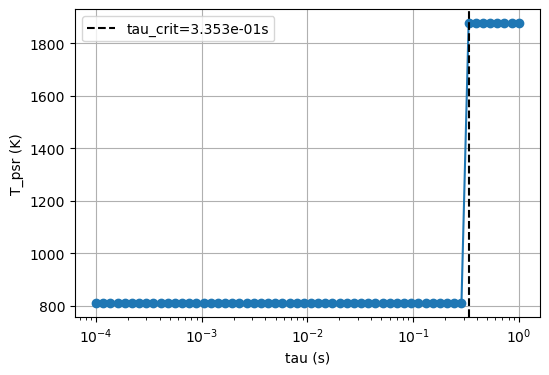

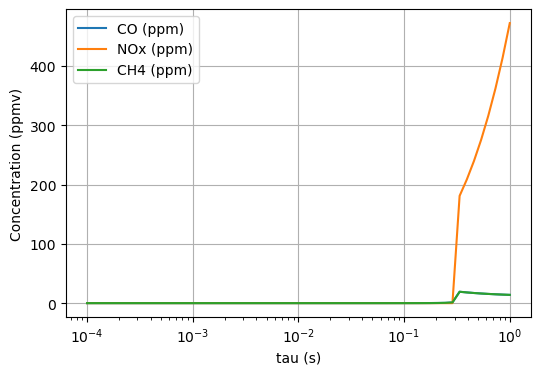

In [40]:
taus = np.logspace(-4, -0.0, 60) 
Tvals = np.zeros_like(taus)
CO_ppm = np.zeros_like(taus)
NOx_ppm = np.zeros_like(taus)
CH4_ppm = np.zeros_like(taus)

gas = ct.Solution('grimech30.yaml')

for i, tau in enumerate(taus):
    # recreate gas with inlet HP enthalpy
    
    gas.TPX = T_in, P, X_in
    gas.HP = H_total, P

    psr = ct.IdealGasReactor(gas, energy='on', volume=V_comb)
    upstream = ct.Reservoir(gas)
    downstream = ct.Reservoir(gas)
    
    mdot = psr.mass / tau
    mfc = ct.MassFlowController(upstream, psr, mdot=mdot)
    valve = ct.Valve(psr, downstream, K=0.01)
    net = ct.ReactorNet([psr])
    net.advance_to_steady_state()

    thermo = psr.thermo
    X = psr.thermo.X
    
    Tvals[i] = psr.T
    
    CO_ppm[i] = X[thermo.species_index('CO')] * 1e6
    NOx_ppm[i] = (X[thermo.species_index('NO')] + X[thermo.species_index('NO2')] + X[thermo.species_index('N2O')]) * 1e6
    CH4_ppm[i] = X[thermo.species_index('CO')] * 1e6

# find tau_crit where T crosses 1500 K 
mask = Tvals > 1500.0
tau_crit = taus[mask][0] if np.any(mask) else None
print("tau_crit (T > 1500 K) =", tau_crit)

plt.figure(figsize=(6,4))
plt.semilogx(taus, Tvals, '-o')
plt.axvline(x=tau_crit, color='k', linestyle='--', label=f'tau_crit={tau_crit:.3e}s' if tau_crit else 'no tau_crit')
plt.xlabel('tau (s)')
plt.ylabel('T_psr (K)')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.semilogx(taus, CO_ppm, label='CO (ppm)')
plt.semilogx(taus, NOx_ppm, label='NOx (ppm)')
plt.semilogx(taus, CH4_ppm, label='CH4 (ppm)')
plt.xlabel('tau (s)')
plt.ylabel('Concentration (ppmv)')
plt.legend()
plt.grid(True)
plt.show()

Methane fuel enters at **300 K** instead of 850 K -> the mixed inlet stream cools to **≈329 K** → lowers the initial reaction temperature and delays the ignition. 

**Adiabatic flame temperature** drops slightly from **1902 K → 1869 K**, while the **critical residence time** for ignition increases from **≈0.08 s → 0.34 s** → slower ignition and higher likelihood of incomplete combustion.

At the nominal operating residence time (**τ ≈ 0.019 s**), the PSR remains at a low temperature (**810 K**) with a high **CH₄ mole fraction (~4.9×10⁻²)** → mixture fails to ignite. 
Equilibrium **NOx** decreases slightly (**3.94×10⁻³ → 3.56×10⁻³**) due to the lower flame temperature, while **CO** remains very low.

Overall, the colder fuel increases ignition delay and unburned hydrocarbons (UHC), but equilibrium NOx formation is reduced. 
The fuel mass flow should remain unchanged (to keep power output constant), but **fuel preheating or increased residence time** is important to achieve complete combustion without excessive CO or UHC emissions.

### Substituting fuel with hydrogen

- We will compute CH₄ → H₂ mass flows for 50% and 100% substitution (energy basis), for three GE H-class turbines in combined-cycle.

- Then, we compute the electrolyser electricity required to make that H₂ (kWh/kg basis, with a sensible range).

- Finally, we will compute numbers on storage (tank volumes at 700 bar and liquid H₂ density) and pipeline considerations.


Assumptions used in the calculations

Combined-cycle net electrical outputs (representative, 1×1 plant):

**GE 9HA.02**: 838 MW (1x CC net output), $\eta = 64.1%$

**GE 7HA.03**: 640 MW (1× CC net output), $\eta = 63.9%$

**GE 7HA.02**: 573 MW (1× CC net output), $\eta = 63.4%$

Combined-cycle thermal efficiency ($η_{cc}$) assumed 64% (typical H-class CC reported >64%). 
GE Vernova

Lower heating value (LHV): H₂ = 120 MJ/kg, CH₄ = 50 MJ/kg (user gave CH₄ LHV=50 MJ/kg).

Electrolyser electricity usage (system level): 50 kWh/kg H₂ (IRENA / NREL ranges 40–60 kWh/kg; we will USE a small range: 45–60 kWh/kg).

---


**Lower Heating Value of H₂:**  
  $\text{LHV}_{H2} \approx 120~\text{MJ/kg}$ (https://www.engineeringtoolbox.com/fuels-higher-calorific-values-d_169.html)

**Combined-Cycle Efficiency (η_cc):**  
  $
  \eta_{\rm CC} = \frac{P_{\rm net}}{\dot{E}_{\rm fuel}}
  $  
  For representative GE turbines:

  | Turbine | Net output (MW_e) | η reported |
  |---------|-----------------|------------|
  | 9HA.02  | 838             | 64.1%     |
  | 7HA.03  | 640             | 63.9%     |
  | 7HA.02  | 573             | 63.4%     |

  In calculations, η_cc ≈ 0.64 is a reasonable approximation.

- **Hydrogen mass flow calculation:**  
  - Compute required fuel energy input:
  $$
  \dot{E}_{\rm fuel} = \frac{P_{\rm net}}{\eta_{\rm CC}}
  $$ 
  - Compute hydrogen mass flow:
  $$
  \dot{m}_{\rm H_2} = \frac{\dot{E}_{\rm fuel}}{\text{LHV}_{\rm H_2}}
  $$ 

In [47]:
# Compute H2 mass flows 50% and 100% substitution by energy

turbines = {
    '9HA.02_1x': 838.0,   # MW_e 
    '7HA.03_1x' : 640.0,   # MW_e
    '7HA.02_1x' : 573.0    # MW_e
}

eta_cc = 0.64           # combined-cycle efficiency
LHV_H2 = 120e6          # J/kg
LHV_CH4 = 50e6          # J/kg

results = {}
for name, P_net_MW in turbines.items():
    P_net_W = P_net_MW * 1e6
    # chemical energy input required = electrical power / efficiency
    E_fuel_W = P_net_W / eta_cc                # W of chemical energy input
    # H2 mass flows
    mdot_H2_100 = E_fuel_W / LHV_H2            # kg/s for 100% H2
    mdot_H2_50 = 0.5 * E_fuel_W / LHV_H2       # kg/s for 50% H2 (energy fraction)
    # CH4 that supplies the rest in 50% case
    E_CH4_rem_W = E_fuel_W - 0.5 * E_fuel_W
    mdot_CH4_for_half = E_CH4_rem_W / LHV_CH4

    results[name] = {
        'P_net_MW': P_net_MW,
        'E_fuel_MW': E_fuel_W/1e6,
        'mdot_H2_100_kg_s': mdot_H2_100,
        'mdot_H2_50_kg_s': mdot_H2_50,
        'mdot_CH4_when_50pct_H2_kg_s': mdot_CH4_for_half
    }

for name, r in results.items():
    print(f"\n{name}: P_net = {r['P_net_MW']} MW")
    print(f"  Fuel chemical power required = {r['E_fuel_MW']:.1f} MW (thermal input)")
    print(f"  mdot H2 (100% H2) = {r['mdot_H2_100_kg_s']:.4f} kg/s = {r['mdot_H2_100_kg_s']*3600:.1f} kg/h")
    print(f"  mdot H2 (50% energy from H2) = {r['mdot_H2_50_kg_s']:.4f} kg/s = {r['mdot_H2_50_kg_s']*3600:.1f} kg/h")
    print(f"  mdot CH4 (remaining 50% energy) = {r['mdot_CH4_when_50pct_H2_kg_s']:.4f} kg/s = {r['mdot_CH4_when_50pct_H2_kg_s']*3600:.1f} kg/h")



9HA.02_1x: P_net = 838.0 MW
  Fuel chemical power required = 1309.4 MW (thermal input)
  mdot H2 (100% H2) = 10.9115 kg/s = 39281.2 kg/h
  mdot H2 (50% energy from H2) = 5.4557 kg/s = 19640.6 kg/h
  mdot CH4 (remaining 50% energy) = 13.0938 kg/s = 47137.5 kg/h

7HA.03_1x: P_net = 640.0 MW
  Fuel chemical power required = 1000.0 MW (thermal input)
  mdot H2 (100% H2) = 8.3333 kg/s = 30000.0 kg/h
  mdot H2 (50% energy from H2) = 4.1667 kg/s = 15000.0 kg/h
  mdot CH4 (remaining 50% energy) = 10.0000 kg/s = 36000.0 kg/h

7HA.02_1x: P_net = 573.0 MW
  Fuel chemical power required = 895.3 MW (thermal input)
  mdot H2 (100% H2) = 7.4609 kg/s = 26859.4 kg/h
  mdot H2 (50% energy from H2) = 3.7305 kg/s = 13429.7 kg/h
  mdot CH4 (remaining 50% energy) = 8.9531 kg/s = 32231.2 kg/h


**Hydrogen Mass Flow Requirements**

From your calculations, for the GE H-class turbines:

| Turbine | 100% H₂ (kg/s) | 50% H₂ (kg/s) | CH₄ for 50% H₂ (kg/s) |
|---------|----------------|----------------|-----------------------|
| 9HA.02  | 10.91          | 5.46           | 13.09                 |
| 7HA.03  | 8.33           | 4.17           | 10.00                 |
| 7HA.02  | 7.46           | 3.73           | 8.95                  |


Even a 50% energy substitution requires multi-kilogram-per-second hydrogen flows, which is substantial for continuous operation.


In [48]:
# electricity required to produce that H₂ by electrolysis

# Electrolyser electricity required (kW/MW and power)
# Use a range for electricity consumption per kg H2: 45-60 kWh/kg 
kwh_per_kg_range = [45.0, 50.0, 60.0]  # kWh/kg

print("Electrolyser power required (continuous) to produce the H2 mass flows from Block 1:\n")
for name, r in results.items():
    mdot100 = r['mdot_H2_100_kg_s']
    kg_per_hour_100 = mdot100 * 3600.0
    for kwh_per_kg in kwh_per_kg_range:
        elec_kW = kg_per_hour_100 * kwh_per_kg / 1.0  # kW (kg/hr * kWh/kg = kW)
        print(f"{name}, 100% H2, electrolyser usage {kwh_per_kg} kWh/kg -> {elec_kW/1e3:.1f} MW_e of electrolyser power")

    mdot50 = r['mdot_H2_50_kg_s']
    kg_per_hour_50 = mdot50 * 3600.0
    for kwh_per_kg in kwh_per_kg_range:
        elec_kW = kg_per_hour_50 * kwh_per_kg
        print(f"{name}, 50% H2, electrolyser usage {kwh_per_kg} kWh/kg -> {elec_kW/1e3:.1f} MW_e of electrolyser power")
    print("")


Electrolyser power required (continuous) to produce the H2 mass flows from Block 1:

9HA.02_1x, 100% H2, electrolyser usage 45.0 kWh/kg -> 1767.7 MW_e of electrolyser power
9HA.02_1x, 100% H2, electrolyser usage 50.0 kWh/kg -> 1964.1 MW_e of electrolyser power
9HA.02_1x, 100% H2, electrolyser usage 60.0 kWh/kg -> 2356.9 MW_e of electrolyser power
9HA.02_1x, 50% H2, electrolyser usage 45.0 kWh/kg -> 883.8 MW_e of electrolyser power
9HA.02_1x, 50% H2, electrolyser usage 50.0 kWh/kg -> 982.0 MW_e of electrolyser power
9HA.02_1x, 50% H2, electrolyser usage 60.0 kWh/kg -> 1178.4 MW_e of electrolyser power

7HA.03_1x, 100% H2, electrolyser usage 45.0 kWh/kg -> 1350.0 MW_e of electrolyser power
7HA.03_1x, 100% H2, electrolyser usage 50.0 kWh/kg -> 1500.0 MW_e of electrolyser power
7HA.03_1x, 100% H2, electrolyser usage 60.0 kWh/kg -> 1800.0 MW_e of electrolyser power
7HA.03_1x, 50% H2, electrolyser usage 45.0 kWh/kg -> 675.0 MW_e of electrolyser power
7HA.03_1x, 50% H2, electrolyser usage 50.

**Electrolyser Power Requirements**

For 100% and 50% H₂:

| Turbine | 100% H₂ (MWₑ) | 50% H₂ (MWₑ) |
|---------|----------------|----------------|
| 9HA.02  | 1687–2250       | 844–1125       |
| 7HA.03  | 1350–1800       | 675–900        |
| 7HA.02  | 1209–1612       | 604–806        |
 
- Producing enough H₂ requires much more electrical energy than the turbine output.  
- Need for large-scale renewable or grid power.

In [49]:
# storage/transport numbers (compressed gas @700 bar, liquid H₂)

# Approximate storage volumes (ballpark) for the H2 mass flows.

rho_liq_H2 = 70.8   # kg/m3 (liquid hydrogen density, ~70 kg/m3)
# Compressed gas at 700 bar density ~ 39 kg/m3 (depends on temperature); we use ~40 kg/m3 as rough number
rho_gas_700bar = 40.0  # kg/m3 

print("Approximate storage volume needed for 1 hour of H2 (100% H2 case):")
for name, r in results.items():
    kg_per_hour = r['mdot_H2_100_kg_s']*3600.0
    vol_liq_m3 = kg_per_hour / rho_liq_H2
    vol_gas700_m3 = kg_per_hour / rho_gas_700bar
    print(f"{name}: {kg_per_hour:.1f} kg/hr -> liquid volume ≈ {vol_liq_m3:.1f} m^3; compressed@700bar ≈ {vol_gas700_m3:.1f} m^3")


Approximate storage volume needed for 1 hour of H2 (100% H2 case):
9HA.02_1x: 39281.2 kg/hr -> liquid volume ≈ 554.8 m^3; compressed@700bar ≈ 982.0 m^3
7HA.03_1x: 30000.0 kg/hr -> liquid volume ≈ 423.7 m^3; compressed@700bar ≈ 750.0 m^3
7HA.02_1x: 26859.4 kg/hr -> liquid volume ≈ 379.4 m^3; compressed@700bar ≈ 671.5 m^3


**Hydrogen Storage & Transport**

For 1-hour operation at 100% H₂:

| Turbine | Liquid H₂ (m³) | Compressed 700 bar (m³) |
|---------|----------------|-------------------------|
| 9HA.02  | 530            | 938                     |
| 7HA.03  | 424            | 750                     |
| 7HA.02  | 379            | 672                     |

- Storage volumes are large, especially for compressed H₂.  
- Continuous operation or 24-hour storage would require massive infrastructure.

**Feasability**

This analysis evaluates the implications of substituting **50%–100% of natural gas fuel with hydrogen** in combined-cycle gas turbines (CCGTs) and the feasibility of producing that hydrogen using wind power.

---

**Hydrogen Production**

From the calculations:

| Turbine    | Net Power (MW) | H₂ Mass Flow (100%) kg/s | Electrolyser Power (50 kWh/kg) MW_e |
|------------|----------------|-------------------------|------------------------------------|
| 9HA.02     | 838            | 10.91                   | 1964                               |
| 7HA.03     | 640            | 8.33                    | 1500                               |
| 7HA.02     | 573            | 7.46                    | 1343                               |

- Electrolyser capacity required is enormous:
  - 9HA.02 at 100% H₂: ~2 GW continuous electrolyser power.
  - 50% substitution still requires ~1 GW electrolyser power.
- Significant energy losses occur in converting electricity to hydrogen (electrolyser efficiency ~70%).

Producing hydrogen at scale for these turbines is technically feasible but would require large-scale electrolyser capacity.

---

**Hydrogen Storage**

Approximate storage volumes for 1 hour of continuous H₂ supply:

| Turbine    | H₂ Flow (kg/h) | Liquid H₂ Volume (m³) | Compressed H₂ 700 bar (m³) |
|------------|----------------|----------------------|-----------------------------|
| 9HA.02     | 39,281         | 555                  | 982                         |
| 7HA.03     | 30,000         | 424                  | 750                         |
| 7HA.02     | 26,859         | 379                  | 672                         |


- 1-hour storage is feasible in terms of volume.
- Continuous operation requires 24× these volumes (~13,000 m³ for 9HA.02).
- High-pressure compressed storage is larger and more challenging than liquid H₂.

Storage is technically feasible but requires significant infrastructure investment for continuous operation.

---

**Hydrogen Transport**

- Transporting 10–40 t/h of H₂ requires high-pressure pipelines or liquid tankers.

Transport is feasible locally, but scaling across multiple plants or regions is challenging and expensive.

---

**Feasibility with Wind Power**

- 1 GW electrolyser requires ~1 GW average electrical input.
- Modern wind turbines (~10 MW, 35% capacity factor → 3.5 MW average) would require:
  - ~285 turbines for 100% H₂ for 9HA.02
  - ~140 turbines for 50% H₂ substitution

Technically feasible, but requires **massive renewable capacity** and careful integration with electrolyser and turbine operation.

---

- 50% H₂ substitution: minimal turbine modifications needed, manageable.
- 100% H₂: requires turbine adaptation due to different flame characteristics, lower density, and higher NOx risk.
- Efficiency impacts: hydrogen demands higher mass flow due to lower volumetric energy content.

### Is Hydrogen easier to ignite than Methane

According to Snehasish Panigrahy et al. in “When hydrogen is slower than methane to ignite” (Proceedings of the Combustion Institute, Volume 39, Issue 1, 2023), **hydrogen ignites faster than all other fuels**, including methane, at **temperatures above 950 K**. However, at **lower temperatures**, specifically below 890–925 K, depending on the operating pressure and equivalence ratio, **hydrogen mixtures ignite more slowly than methane**. For example, at 40 bar and φ = 1.0, the ignition delay time (IDT) for hydrogen at 890 K is 2.5 times longer than for methane, and at φ = 2.0, the same occurs at 875 K.

At low temperatures, alkyl radicals (Ṙ = ĊH₃ and Ḣ) react with O₂ to form RȮ₂ radicals, which then react with HȮ₂ radicals to produce ROOH species (such as H₂O₂ and CH₃OOH) and O₂. For hydrogen, HȮ₂ self-recombination propagates the reaction chain in a way that inhibits overall reactivity. In contrast, for methane, the interaction between RȮ₂ (CH₃OȮ) and HȮ₂ leads to chain branching, which enhances reactivity. Additionally, CH₃OOH decomposes more readily to form CH₃Ȯ and ȮH radicals than H₂O₂ does to produce two ȮH radicals. As a result, at low temperatures, mixtures with higher hydrogen content ignite more slowly than mixtures with higher methane content.